<h1>Содержание проекта<span class="tocSkip"></span></h1>

1  Загрузка, изучение, обработка данных

2  Ресемплирование

3  Анализ данных

4  Обучение моделей

    4.1  Подготовка признаков
    4.2  Создание выборок
    4.3  Обучение моделей
        4.3.1  LinearRegression
        4.3.2  RandomForestRegressor
        4.3.3  DecisionTreeRegressor
        4.3.4  LightGBM
        4.3.5  CatBoostRegressor
        4.3.6  Выводы
    
5  Тестирование

6  Общий вывод

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.


# Цели и задачи проекта

**Цель проекта:** Постройте модель для предсказания количество заказов такси на следующий час.

**Условия задачи:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**План выполнения работ:**

1. Загрузить, изучить, при необходимости обработать данные


2. Выполнить ресемплирование данных по одному часу.


3. Проанализировать данные.


4. Обучить модели

    4.1. Подготовить признаки.   
    4.2. Сделать тестовую выборку размером 10% от исходных данных.    
    4.3. Обучить разные модели с различными гиперпараметрами.
    
    
5. Проверить данные на тестовой выборке и сделать выводы.

**Дополнительная информация:**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Загрузка, изучение, обработка данных

In [1]:
#импорты настройки функции

import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(16,6)})
sns.set_palette('dark:#5A9_r')

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
    
# для оценки времени
from tqdm.auto import tqdm
import time

# остальное
import warnings
warnings.filterwarnings('ignore')

# функция для линейного графика
def sns_lineplot(dt, chart_title):
    dt.plot()
    plt.title(chart_title)
    plt.show()
    
# функция для графика ящик с усами
def sns_boxplot(dt, chart_title):
    sns.boxplot(x=dt)
    plt.title(chart_title)
    plt.show()
    
# функция для создания признаков
def make_features(data, max_lag):
    # основные признаки
    
    # месяц - не нужен, какой смысл, если данные за пол года
    #data['month'] = data.index.month
    
    # день пусть будет, протестируем, это же порядковый номер в месяце
    data['day'] = data.index.day
    # день недели так же
    data['dayofweek'] = data.index.dayofweek
    # час по идее нужен обязательно, у нас же семпл по часам
    data['hour'] = data.index.hour
    
    # признаки отстающих значений
    # в нашем случае цикл пусть будет, хотя >2 lag вряд ли окажется полезным
    for lag in max_lag:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    # добавим признак rolling_mean
    # мы ж не будем никак обрабатывать данные, нормализировать например, этот признак в помощь
    # потому что конкретное значение, еще и с учетом того что кол-ва растут со временем, вряд ли придет на входе
    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data['rolling_mean_12'] = data['num_orders'].shift().rolling(12).mean()
    data['rolling_mean_24'] = data['num_orders'].shift().rolling(24).mean()
    data['rolling_mean_48'] = data['num_orders'].shift().rolling(48).mean()
    
    # и сразу убираем NA
    data.dropna(inplace=True)
    
    return data

**Загрузим файл и посмотрим на данные.**

In [2]:
# быстро посмотрим что там у нас
pd.read_csv("/datasets/taxi.csv").head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
# загружаем данные, сразу назначая дату индексом
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [4]:
display(data.head())
print()
print(data.info())
print()
print('Полных дубликатов:', sum(data.duplicated()))
#display(data.loc[data.duplicated()])
print()
print('Describe:')
display(data.describe())
print()
print('datetime min:',data.index.min())
print('datetime max:',data.index.max())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Полных дубликатов: 26415

Describe:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



datetime min: 2018-03-01 00:00:00
datetime max: 2018-08-31 23:50:00


**Имеем следующий набор данных c марта по август 2018:**

  - `datetime` — индекс, дата
  - `num_orders` — целевой признак, кол-во заказов
    
Целевым будет признак num_orders, остальные признаки мы создадим на сл. этапах.

Проверим, есть ли пропуски

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

Посмотрим как распределены данные

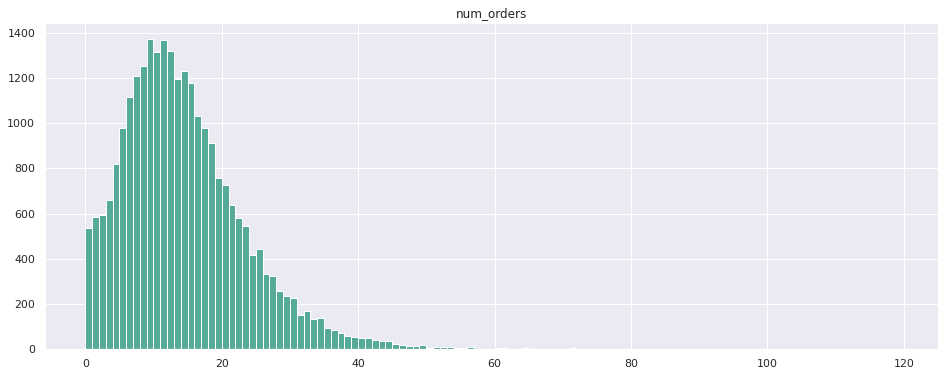

In [6]:
data.hist(bins=data['num_orders'].max());

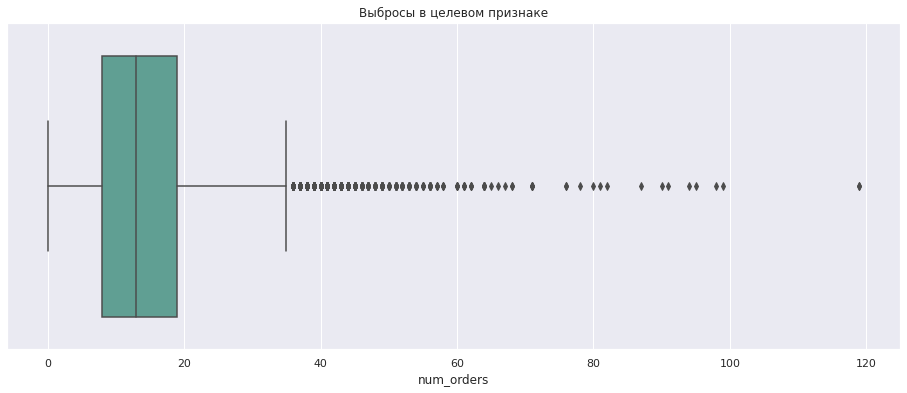

In [7]:
sns_boxplot(data['num_orders'],'Выбросы в целевом признаке')

Как мы видим, данные распределены в целом нормально, выбросы присутствуют, но избавляться от них мы не будем.

**Выводы:**
- загрузили и изучили данные
- проверили дубликаты, пропуски, выбросы

## Ресемплирование

Обязательно сначала проверим индекс на монотонность (должно быть True)

In [8]:
data.index.is_monotonic

True

Теперь ресемплируем наши данных данные по часу

In [9]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Выводы:**
- проверили монотонность индекса (успешно)
- ресемплировали данные по одному часу, проверили

## Анализ данных

**Посмотрим на трендовую, сезонную и шумовую составляющие данных**

In [10]:
# разложим данные
decomp = seasonal_decompose(data)

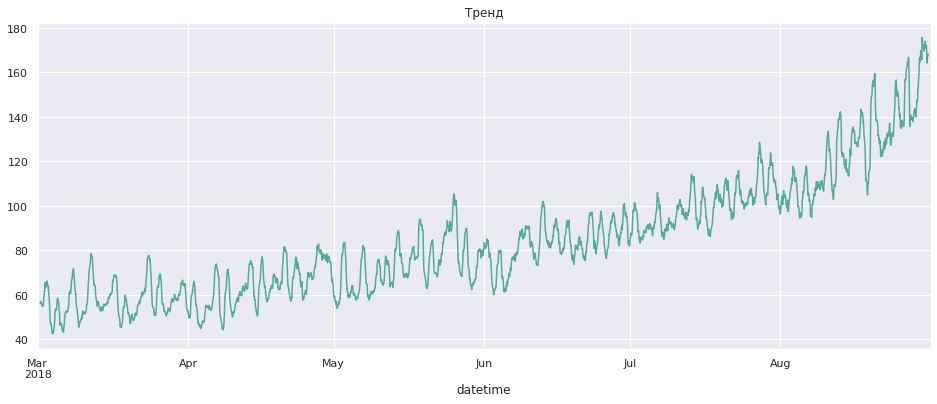

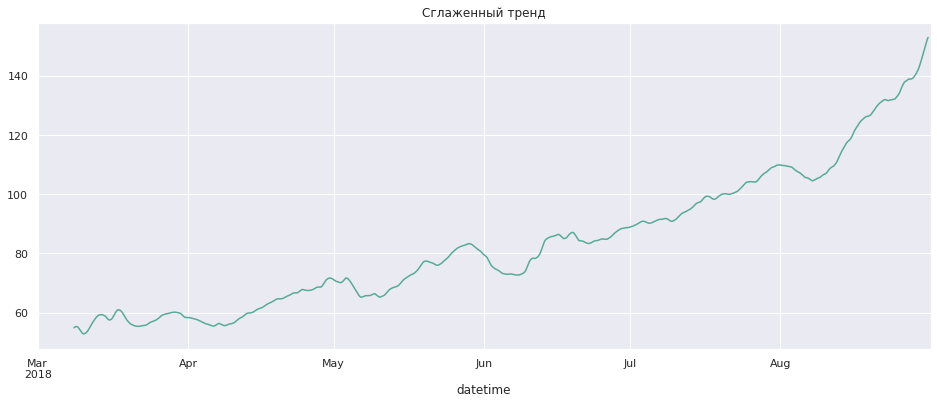

In [11]:
sns_lineplot(decomp.trend, 'Тренд')
sns_lineplot(decomp.trend.rolling(24*7).mean(), 'Сглаженный тренд');

Видим тренд роста кол-ва заказов, с небольшими просадками.

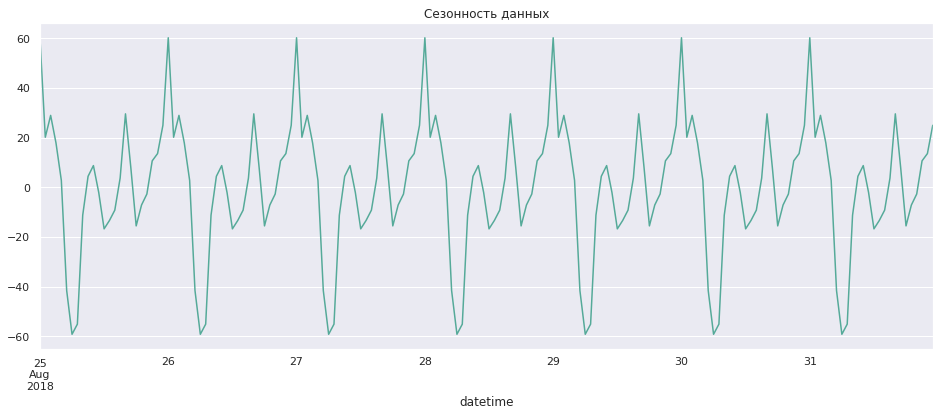

In [12]:
sns_lineplot(decomp.seasonal.tail(24*7), 'Сезонность данных')

Наблюдаем сезонность по дням, у нас спады ночью, скачки роста утром, в обед и пик - вечером.

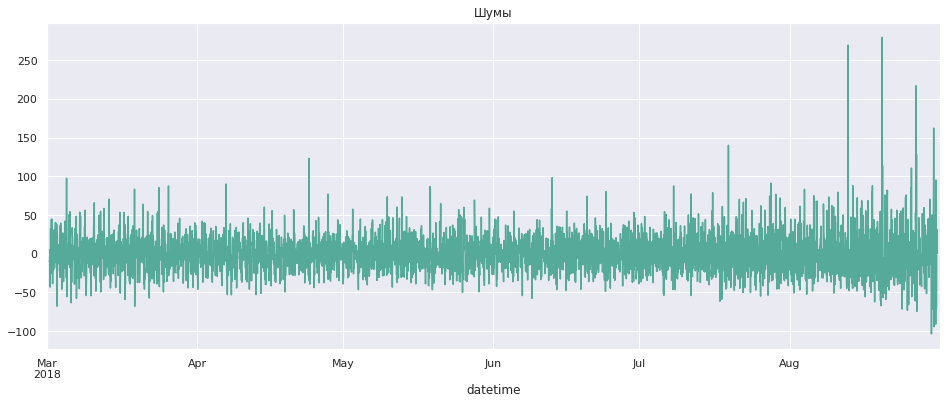

In [13]:
# resid - компонента, которая не объясняется трендом и сезонностью, это шум.
sns_lineplot(decomp.resid, 'Шумы')

**Выводы:**
- Видим тренд равномерного роста заказов с периодическими небольшими просадками
- Видим сезонность по дням - спады заказов ночью, скачки роста утром, в обед и пик - вечером.

## Обучение моделей

Нам необходимо обучить разные модели, возьмем: LinearRegression, RandomForestRegressor, DecisionTreeRegressor, LightGBM и CatBoostRegressor.

Помним, что значение метрики RMSE на тестовой выборке должно будет быть не больше 48.

### Подготовка признаков

Добавим в датасет признаки с горизонтом прогнозирования в один шаг.

In [14]:
data_learn = data.copy()
data_learn = make_features(data_learn, [2,4,12,24,48])
print('Оригинальные данные:')
display(data.head())
print(data.shape)
print()
print('Данные для обучения с признаками:')
display(data_learn.head())
print(data_learn.shape)

Оригинальные данные:


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


(4416, 1)

Данные для обучения с признаками:


,num_orders,day,dayofweek,hour,lag_2,lag_4,lag_12,lag_24,lag_48,rolling_mean,rolling_mean_12,rolling_mean_24,rolling_mean_48
datetime,,,,,,,,,,,,,
2018-03-03 00:00:00,163,3,5,0,119.0,93.0,36.0,90.0,124.0,72.0,72.666667,62.750000,59.791667
2018-03-03 01:00:00,108,3,5,1,72.0,101.0,45.0,120.0,85.0,163.0,83.250000,65.791667,60.604167
2018-03-03 02:00:00,25,3,5,2,163.0,119.0,44.0,75.0,71.0,108.0,88.500000,65.291667,61.083333
2018-03-03 03:00:00,64,3,5,3,108.0,72.0,59.0,64.0,66.0,25.0,86.916667,63.208333,60.125000
2018-03-03 04:00:00,44,3,5,4,25.0,163.0,82.0,20.0,43.0,64.0,87.333333,63.208333,60.083333


(4368, 13)


Создали датасет для обучения с новыми признаками.

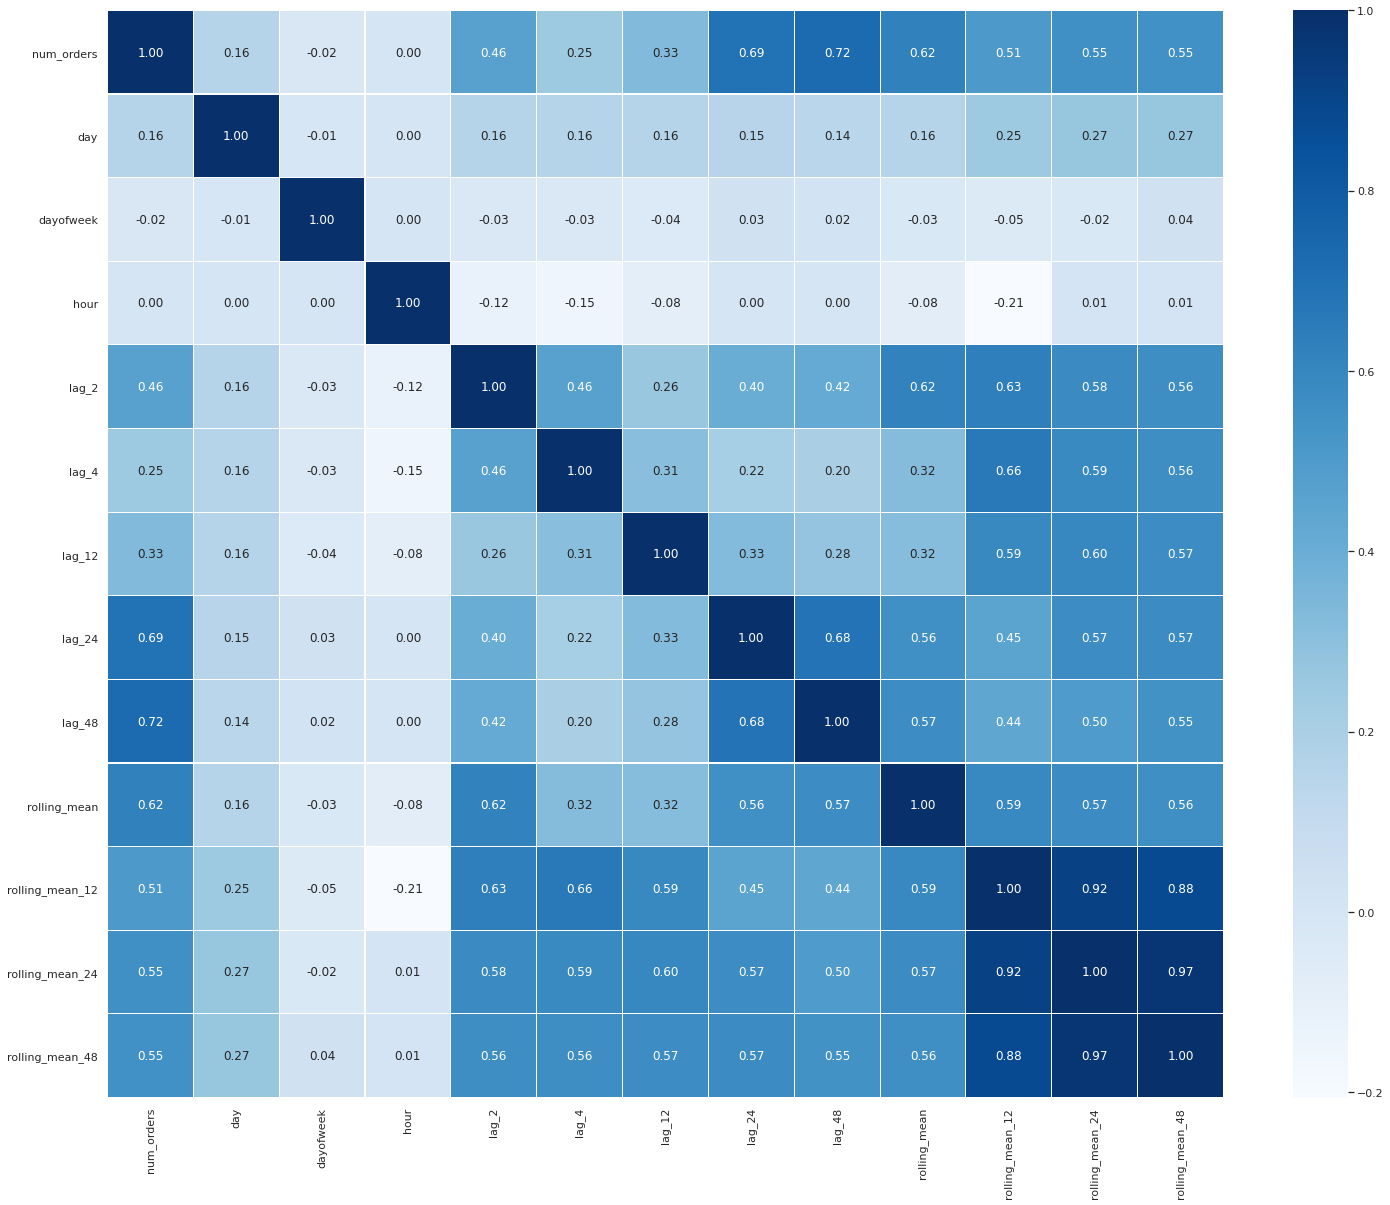

In [15]:
fig, ax = plt.subplots(figsize=(25,20)) 
sns.heatmap(data_learn.corr(), cmap="Blues", annot=True, fmt='.2f', linewidth=.1,ax=ax);
plt.show();

Подготовили признаки с учетом особенностей данных, проанализировали их.

При этом видим, что день недели и час, казалось бы, основные важные признаки, - почти ни с чем не коррелируют. Но убирать мы их не будем.

### Создание выборок

Разделим данные на обучающую, валидационную и тестовую выборки

In [16]:
# создаем признаки и класс
features = data_learn.drop(['num_orders'], axis=1)
target = data_learn['num_orders']

# разобьем на выборки (!!! shuffle=False)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

# и сделаем валидационные выборки
features_train, features_val, target_train, target_val = train_test_split(
    features_train, target_train, shuffle=False, test_size=0.1, random_state=12345
)

Создали признаки, класс, разбили на три выборки.

### Обучение моделей

Мы будем создавать модели LinearRegression, RandomForestRegressor, DecisionTreeRegressor, LightGBM и CatBoostRegressor.

Результаты сразу запишем, чтобы потом подытожить.

In [17]:
all_results = {}

#### LinearRegression

In [18]:
model_name = 'LinearRegression'
# параметры для тестирования

print()
print(f"{model_name}")

model = LinearRegression()

start_learn = time.time()
model.fit(features_train, target_train)
end_learn = time.time()

start_predict = time.time()
predictions = model.predict(features_val)
end_predict = time.time()

rmse = mean_squared_error(target_val, predictions, squared=False)
   
result = {
    'params':{},
    'result':{
        'rmse':rmse,
        'time_learn':(end_learn - start_learn),
        'time_predict':(end_predict - start_predict)
    },
    'model': model
}

all_results[model_name] = result

print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)}")


LinearRegression
Лучшая модель: RMSE 32.46973682149665
Скорость обучения: 0.004170894622802734
Скорость предсказания: 0.0019860267639160156
Параметры: {}

LinearRegression показала минимальную RMSE 32.47


#### RandomForestRegressor

In [19]:
model_name = 'RandomForestRegressor'

p_max_depth = range(12,17,2)
p_n_estimators = range(300,901,300)

pbar = tqdm(total=len(p_max_depth)*len(p_n_estimators))

print()
print(f"{model_name}")

min_rmse = 10**10
for max_depth in p_max_depth:
    for n_estimators in p_n_estimators:
    
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train)
        end_learn = time.time()
        
        start_predict = time.time()
        predictions = model.predict(features_val)
        end_predict = time.time()

        rmse = mean_squared_error(target_val, predictions, squared=False)
        
        print()
        print('RMSE =',rmse)
        print(f'Параметры: max_depth={max_depth}, n_estimators={n_estimators}')
        print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')
        
        if(rmse<min_rmse):
            min_rmse=rmse
            result = {
                'params':{
                    'n_estimators':n_estimators,
                    'max_depth':max_depth
                },
                'result':{
                    'rmse':rmse,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict)
                },
                'model': model
            }
        pbar.update()
pbar.close()

print()
print()

all_results[model_name] = result

  0%|          | 0/9 [00:00<?, ?it/s]


RandomForestRegressor

RMSE = 34.0382924791792
Параметры: max_depth=12, n_estimators=300
Время обучения: 4.959192752838135, Предсказания 0.03842973709106445

RMSE = 33.89526204803675
Параметры: max_depth=12, n_estimators=600
Время обучения: 11.773017883300781, Предсказания 0.08172750473022461

RMSE = 33.90844682188985
Параметры: max_depth=12, n_estimators=900
Время обучения: 14.546697616577148, Предсказания 0.11817383766174316

RMSE = 33.96869546953762
Параметры: max_depth=14, n_estimators=300
Время обучения: 5.349737644195557, Предсказания 0.05336451530456543

RMSE = 33.83883850184938
Параметры: max_depth=14, n_estimators=600
Время обучения: 10.709139585494995, Предсказания 0.08291769027709961

RMSE = 33.86108864206535
Параметры: max_depth=14, n_estimators=900
Время обучения: 16.172160625457764, Предсказания 0.1257479190826416

RMSE = 33.86375744341343
Параметры: max_depth=16, n_estimators=300
Время обучения: 5.60130500793457, Предсказания 0.045064449310302734

RMSE = 33.826042046872

In [20]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)}")

Лучшая модель: RMSE 33.82604204687284
Скорость обучения: 11.209731578826904
Скорость предсказания: 0.09274506568908691
Параметры: {'n_estimators': 600, 'max_depth': 16}

RandomForestRegressor показала минимальную RMSE 33.83


#### DecisionTreeRegressor

In [21]:
model_name = 'DecisionTreeRegressor'

p_max_depth = range(3,8,1)

pbar = tqdm(total=len(p_max_depth))

print()
print(f"{model_name}")

min_rmse = 10**10
for max_depth in p_max_depth:

    model = DecisionTreeRegressor(
        max_depth=max_depth,
        random_state=12345
    )

    start_learn = time.time()
    model.fit(features_train, target_train)
    end_learn = time.time()

    start_predict = time.time()
    predictions = model.predict(features_val)
    end_predict = time.time()

    rmse = mean_squared_error(target_val, predictions, squared=False)

    print()
    print('RMSE =',rmse)
    print(f'Параметры: max_depth={max_depth}')
    print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')

    if(rmse<min_rmse):
        min_rmse=rmse
        result = {
            'params':{
                'max_depth':max_depth
            },
            'result':{
                'rmse':rmse,
                'time_learn':(end_learn - start_learn),
                'time_predict':(end_predict - start_predict)
            },
            'model': model
        }
    pbar.update()
pbar.close()

print()
print()

all_results[model_name] = result

  0%|          | 0/5 [00:00<?, ?it/s]


DecisionTreeRegressor

RMSE = 37.93970992576506
Параметры: max_depth=3
Время обучения: 0.009517669677734375, Предсказания 0.0018439292907714844

RMSE = 37.34863801942074
Параметры: max_depth=4
Время обучения: 0.009885311126708984, Предсказания 0.0014395713806152344

RMSE = 36.768802710829725
Параметры: max_depth=5
Время обучения: 0.012287616729736328, Предсказания 0.0014498233795166016

RMSE = 39.94638040468849
Параметры: max_depth=6
Время обучения: 0.013338088989257812, Предсказания 0.0014181137084960938

RMSE = 42.233385841249515
Параметры: max_depth=7
Время обучения: 0.034996986389160156, Предсказания 0.001971006393432617




In [22]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)}")

Лучшая модель: RMSE 36.768802710829725
Скорость обучения: 0.012287616729736328
Скорость предсказания: 0.0014498233795166016
Параметры: {'max_depth': 5}

DecisionTreeRegressor показала минимальную RMSE 36.77


#### LightGBM

In [23]:
model_name = 'LightGBM'

# на локальной машине с гпу гонял, - результаты от перебора пар-в почти не меняются
#p_iters = range(50,451,50)
#p_depth = range(4,13,2)
p_iters = [50]
p_depth = [8]

pbar = tqdm(total=len(p_iters)*len(p_depth))

print()
print(f"{model_name}")

min_rmse = 10**10
for depth in p_depth:
    for iterations in p_iters:
    
        model = lgb.LGBMRegressor(
            metric='rmse',
            num_iterations=iterations,
            max_depth=depth,
            random_seed=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train, verbose=False)
        end_learn = time.time()
        
        start_predict = time.time()
        predictions = model.predict(features_val)
        end_predict = time.time()

        rmse = mean_squared_error(target_val, predictions, squared=False)
        
        print()
        print('RMSE =',rmse)
        print(f'Параметры: max_depth={depth}, num_iterations={iterations}')
        print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')
        
        
        if(rmse<min_rmse):
            min_rmse=rmse
            result = {
                'params':{
                    'num_iterations':iterations,
                    'max_depth':depth
                },
                'result':{
                    'rmse':rmse,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict)
                },
                'model': model
            }
        pbar.update()
pbar.close()

print()
print()
all_results[model_name] = result

  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM

RMSE = 31.56070488845502
Параметры: max_depth=8, num_iterations=50
Время обучения: 0.45423364639282227, Предсказания 0.09446883201599121




In [24]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)}")

Лучшая модель: RMSE 31.56070488845502
Скорость обучения: 0.45423364639282227
Скорость предсказания: 0.09446883201599121
Параметры: {'num_iterations': 50, 'max_depth': 8}

LightGBM показала минимальную RMSE 31.56


#### CatBoostRegressor

In [25]:
model_name = 'CatBoostRegressor'

p_iters = range(25,101,25)
p_depth = range(2,9,2)

pbar = tqdm(total=len(p_iters)*len(p_depth))

print()
print(f"{model_name}")

min_rmse = 10**10
for depth in p_depth:
    for iterations in p_iters:
    
        model = CatBoostRegressor(
            loss_function='RMSE',
            iterations=iterations,
            depth=depth,
            random_seed=12345
        )

        start_learn = time.time()
        model.fit(features_train, target_train, verbose=False)
        end_learn = time.time()
        
        start_predict = time.time()
        predictions = model.predict(features_val)
        end_predict = time.time()

        rmse = mean_squared_error(target_val, predictions, squared=False)
        
        print()
        print('RMSE =',rmse)
        print(f'Параметры: depth={depth}, iterations={iterations}')
        print(f'Время обучения: {(end_learn - start_learn)}, Предсказания {(end_predict - start_predict)}')
        
        if(rmse<min_rmse):
            min_rmse=rmse
            result = {
                'params':{
                    'iterations':iterations,
                    'depth':depth
                },
                'result':{
                    'rmse':rmse,
                    'time_learn':(end_learn - start_learn),
                    'time_predict':(end_predict - start_predict)
                },
                'model': model
            }
        pbar.update()
pbar.close()

print()
print()

all_results[model_name] = result

  0%|          | 0/16 [00:00<?, ?it/s]


CatBoostRegressor

RMSE = 32.27557230553898
Параметры: depth=2, iterations=25
Время обучения: 0.9393606185913086, Предсказания 0.0014243125915527344

RMSE = 31.27059600439107
Параметры: depth=2, iterations=50
Время обучения: 0.755692720413208, Предсказания 0.0010368824005126953

RMSE = 30.823662590933516
Параметры: depth=2, iterations=75
Время обучения: 0.6603336334228516, Предсказания 0.0009007453918457031

RMSE = 31.73062992218885
Параметры: depth=2, iterations=100
Время обучения: 0.7795720100402832, Предсказания 0.0010097026824951172

RMSE = 32.1406759203037
Параметры: depth=4, iterations=25
Время обучения: 0.7300279140472412, Предсказания 0.0009694099426269531

RMSE = 32.88420969674313
Параметры: depth=4, iterations=50
Время обучения: 0.5998423099517822, Предсказания 0.0009503364562988281

RMSE = 31.20550014258281
Параметры: depth=4, iterations=75
Время обучения: 0.6431441307067871, Предсказания 0.0010724067687988281

RMSE = 31.72172877802654
Параметры: depth=4, iterations=100
Вре

In [26]:
print(f"Лучшая модель: RMSE {result['result']['rmse']}")
print(f"Скорость обучения: {result['result']['time_learn']}")
print(f"Скорость предсказания: {result['result']['time_predict']}")
print('Параметры:',result['params'])
print()
print(f"{model_name} показала минимальную RMSE {round(result['result']['rmse'],2)}")

Лучшая модель: RMSE 30.823662590933516
Скорость обучения: 0.6603336334228516
Скорость предсказания: 0.0009007453918457031
Параметры: {'iterations': 75, 'depth': 2}

CatBoostRegressor показала минимальную RMSE 30.82


#### Выводы

**Посмотрим на сводную таблицу результатов по всем моделям**

In [27]:
df_data = []
for model, model_result in all_results.items():
    df_data.append([
        model,
        round(model_result['result']['rmse'],2),
        str(round(model_result['result']['time_learn'],3))+' сек.',
        str(round(model_result['result']['time_predict'],3))+' сек.',
        str(model_result['params'])
    ])
df = pd.DataFrame(df_data, columns=['Модель', 'RMSE',
                                    'Скорость обучения', 'Скорость предсказания', 'Параметры'])
df = df.sort_values('RMSE',ascending=True)
df.style.hide_index()

Модель,RMSE,Скорость обучения,Скорость предсказания,Параметры
CatBoostRegressor,30.820000,0.66 сек.,0.001 сек.,"{'iterations': 75, 'depth': 2}"
LightGBM,31.560000,0.454 сек.,0.094 сек.,"{'num_iterations': 50, 'max_depth': 8}"
LinearRegression,32.470000,0.004 сек.,0.002 сек.,{}
RandomForestRegressor,33.830000,11.21 сек.,0.093 сек.,"{'n_estimators': 600, 'max_depth': 16}"
DecisionTreeRegressor,36.770000,0.012 сек.,0.001 сек.,{'max_depth': 5}


**Как мы видим по предсказанию на валидационной выборке:**
- Все модели показали RMSE меньше максимально допустимого (48).
- Самая большая ошибка у модели DecisionTreeRegressor
- Самая малая ошибка у модели CatBoostRegressor

**Лучшая модель:**
- CatBoostRegressor	
    RMSE (valid) 30.82
    Скорость обучения	3.864 сек.
    Скорость предсказания	0.001 сек.	
    Параметры `{'iterations': 75, 'depth': 2}`

## Тестирование

**Протестируем лучшую модель на тестовой выборке.**

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [30]:
df_data = []

top_model = all_results['CatBoostRegressor']['model']

# делаем предсказание сохраненной лучшей моделью по тестовым данным
start_predict = time.time()
predictions_test = top_model.predict(features_test)    
end_predict = time.time()

# считаем rmse test
rmse_test = mean_squared_error(target_test, predictions_test, squared=False)

df_data.append([
    'CatBoostRegressor',
    round(rmse_test,2),
    round(all_results['CatBoostRegressor']['result']['rmse'],2),
    str(round(all_results['CatBoostRegressor']['result']['time_learn'],3))+' сек.',
    str(round((end_predict-start_predict),3))+' сек.',
    str(all_results['CatBoostRegressor']['params'])
])
df = pd.DataFrame(df_data, columns=['Модель', 'RMSE TEST', 'RMSE valid',
                                    'Скорость обучения', 'Скорость предск. TEST', 'Параметры'])

df = df.sort_values('RMSE TEST',ascending=True)
df.style.hide_index()

Модель,RMSE TEST,RMSE valid,Скорость обучения,Скорость предск. TEST,Параметры
CatBoostRegressor,47.310000,30.820000,0.66 сек.,0.001 сек.,"{'iterations': 75, 'depth': 2}"


Как мы видим, модель CatBoostRegressor показывает RMSE=47.31 (меньше максимально допустимиого 48) на тестовой выборке.

**Задача решена.**

## Общий вывод

Перед нами стояли следующие цели и задачи:

**Цель проекта:** Постройте модель для предсказания количество заказов такси на следующий час.

**Условия задачи:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Мы выполнили работы:**

1. Загрузили, изучили и обработали данные
    - загрузили и изучили данные
    - проверили дубликаты, пропуски, выбросы


2. Выполнили ресемплирование данных по одному часу.
    - проверили монотонность индекса (успешно)
    - ресемплировали данные по одному часу, проверили
    

3. Проанализировали данные

    Посмотрели на трендовую, сезонную и шумовую составляющие данных:
    - тренд равномерного роста заказов с периодическими небольшими просадками
    - сезонность по дням - спады заказов ночью, скачки роста утром, в обед и пик - вечером.
    
    
4. Обучили модели

    4.1. Подготовили признаки с учетом особенностей данных.   
    4.2. Сделали тесестовую выборку размером 10% от исходных данных, валидационную 10% от обучающей.  
    4.3. Обучить разные модели с различными гиперпараметрами и нашли лучшие:
    
        По результатам прогнозирования по валидационной выборке:
    
        - LinearRegression
        LinearRegression показала минимальную RMSE 32.47
        
        - RandomForestRegressor
        RandomForestRegressor показала минимальную RMSE 33.83
        Параметры: {'n_estimators': 600, 'max_depth': 16}


        - DecisionTreeRegressor
        DecisionTreeRegressor показала минимальную RMSE 36.77
        Параметры: {'max_depth': 5}

        - LightGBM (очень долго учится)
        LightGBM показала минимальную RMSE 31.56
        Параметры: {'num_iterations': 50, 'max_depth': 8}

        - CatBoostRegressor
        CatBoostRegressor показала минимальную RMSE 30.82
        Параметры: {'iterations': 75, 'depth': 2}
        
        - Все модели показали RMSE меньше максимально допустимого (48).
        - Самая большая ошибка у модели DecisionTreeRegressor
        - Самая малая ошибка у модели CatBoostRegressor
        
        Лучшая модель:
        - CatBoostRegressor	
            RMSE (valid) 30.82
            Скорость обучения	3.864 сек.
            Скорость предсказания	0.001 сек.	
            Параметры `{'iterations': 75, 'depth': 2}`
    
    
5. Проверили данные на тестовой выборке и сделали выводы.

   Модель CatBoostRegressor показывает RMSE=47.31 (меньше максимально допустимиого 48) на тестовой выборке.

    Поставленные задачи выполнены.